In [1]:
import qiskit
from qoop.core import state
from qoop.compilation.qsp import QuantumStatePreparation
from qoop.evolution.environment_synthesis import MetadataSynthesis
from qoop.evolution.generator import by_num_rotations,by_num_rotations_and_cnot


def fitnessW(qc: qiskit.QuantumCircuit):
    qsp = QuantumStatePreparation(
        u = qc,
        target_state = state.w(num_qubits = 3).inverse()
    ).fit(num_steps = 100)
    return 1 - qsp.compiler.metrics['loss_fubini_study'][-1] # Fitness value

env_metadata = MetadataSynthesis(
    num_qubits = 3, # As its name
    num_cnot= 10,
    depth = 10, # Ansatz depth you want
    num_circuit = 8, # Number of ansatz per generation
    num_generation = 10, # Number of generation/iteration for GA
    prob_mutate = 0.01 # Mutation probability, usually as small as 0.01 (1%)
)

"""env = EEnvironment(
    metadata = env_metadata,
    fitness_func = fitnessW,
).evol()"""

'env = EEnvironment(\n    metadata = env_metadata,\n    fitness_func = fitnessW,\n).evol()'

5


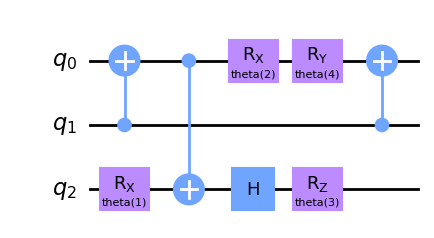

In [10]:
env_metadata = MetadataSynthesis(
    num_qubits=3,
    num_cnot=3,
    num_rx=2,
    num_ry=1,
    num_rz=1,
    depth=5,
    num_circuit=4,
    num_generation=10,
    prob_mutate=0.01
)

from qoop.evolution.generator import by_num_rotations

qc = by_num_rotations_and_cnot(env_metadata)
print(qc.depth())
qc.draw('mpl')

12


d:\Anaconda-Env\GAqiskit\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


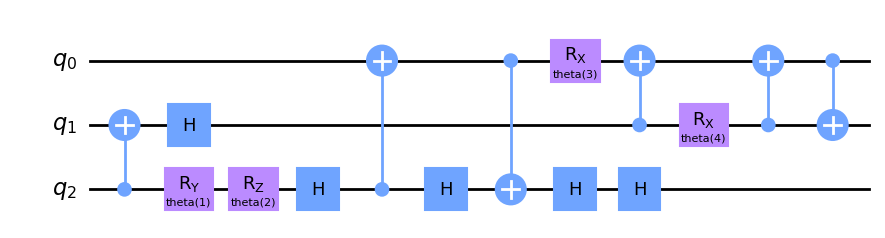

In [11]:
env_metadata = MetadataSynthesis(
    num_qubits=3,
    num_cnot=3,
    num_rx=2,
    num_ry=1,
    num_rz=1,
    depth=5,
    num_circuit=4,
    num_generation=10,
    prob_mutate=0.01
)

from qoop.evolution.generator import by_num_rotations

qc = by_num_rotations(env_metadata)
print(qc.depth())
qc.draw('mpl')